# Exploratory Data Analysis (EDA)

In [0]:
import concurrent.futures
import itertools
import os
import pickle
import random
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import scipy
from scipy import ndimage
from sklearn import metrics
from sklearn.utils import shuffle
import io
import collections

import urllib.request
from urllib.error import HTTPError

In [0]:
import pandas as pd
import seaborn as sns

sns.set(style="white")

In [0]:
class Trajectory(
    collections.namedtuple('Trajectory', [
        'step_type',
        'observation',
        'action',
        'policy_info',
        'next_step_type',
        'reward',
        'discount',
    ])):
  """Stores the observation the agent saw and the action it took.
      The rest of the attributes aren't used in this code."""
  __slots__ = ()

class ListWrapper(object):
  def __init__(self, list_to_wrap):
    self._list = list_to_wrap

  def as_list(self):
    return self._list

class RenameUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
      if name == "Trajectory":
        return Trajectory
      if name == "ListWrapper":
        return ListWrapper

      return super(RenameUnpickler, self).find_class(module, name)

def rename_load(s):
    """Helper function analogous to pickle.loads()."""
    return RenameUnpickler(s, encoding='latin1').load()

In [0]:
def load_file(full_path):
  try:
    with urllib.request.urlopen(full_path) as f:
      data = rename_load(f)
    return data
  except HTTPError:
    pass

def all_load_data(base_path):
  executor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
  
  futures = []
  for i in range(5000):
    full_path = os.path.join(base_path, "ts"+str(i)+".pickle?raw=true")
    future = executor.submit(load_file, full_path)
    futures.append(future)

  raw_data = []
  for future in concurrent.futures.as_completed(futures):
    result = future.result()
    if result:
      raw_data.append(result)

  return raw_data

# Need this useless load or else the all_load_data will hang forever the first time it's called.
load_file("https://github.com/arunraja-hub/Preference_Extraction/blob/master/data/simple_env_1/ts10.pickle?raw=true")

all_raw_data = all_load_data("https://github.com/arunraja-hub/Preference_Extraction/blob/master/data/simple_env_1/")

In [6]:
len(all_raw_data)

475

In [10]:
all_raw_data[0].observation.shape

(50, 14, 16, 5)

In [0]:
activations = []
observations = []
preferences = []

In [0]:
for data in all_raw_data:
  for i in range(data.observation.shape[0]):
    observations.append(np.copy(data.observation[i]))
    activations.append(np.copy(data.policy_info["activations"][i]))
    preferences.append(data.policy_info['satisfaction'].as_list()[i])

In [0]:
observations = np.array(observations)
activations = np.array(activations)
preferences = np.array(preferences)

In [19]:
activations.shape

(23750, 64)

In [20]:
475 * 50

23750

## Activations

In [0]:
act_df = pd.DataFrame(activations)

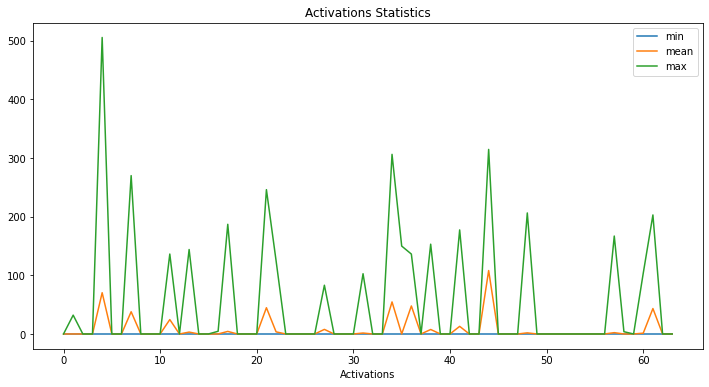

In [79]:
plt.figure(figsize=(12,6))
plt.title('Activations Statistics')
plt.plot(act_df.min(), label='min')
plt.plot(act_df.mean(), label='mean')
plt.plot(act_df.max(), label='max')
plt.xlabel('Activations')
plt.legend()
plt.show()

In [78]:
# Number of non-zero activations
(act_df.max() > 0).sum()

22

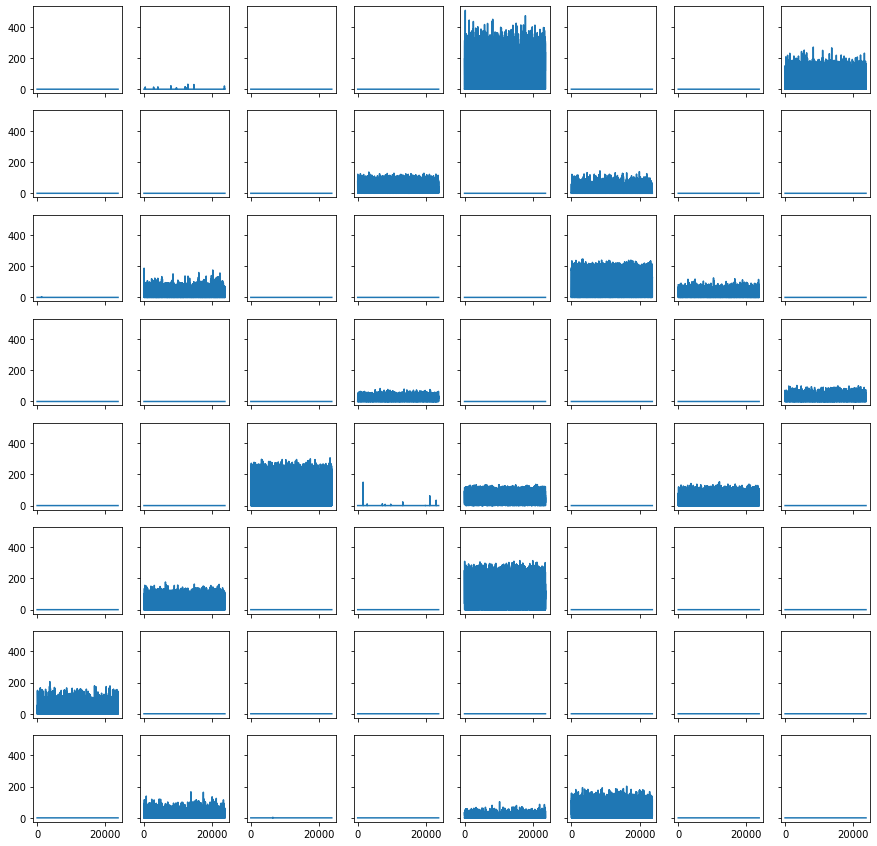

In [80]:
# Activations plots
fig, axs = plt.subplots(8, 8, figsize=(15, 15), sharex=True, sharey=True)

for x in range(activations.shape[1]):
    axs[int(x/8), x%8].plot(activations[:,x])

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

In [0]:
non_zero_acts = act_df.loc[:,act_df.max() > 0]

In [89]:
non_zero_acts.head()

,1,4,7,11,13,16,17,21,22,27,31,34,35,36,38,41,44,48,57,58,60,61
0,0.0,0.000000,0.000000,76.996277,0.0,0.0,24.11171,0.000000,80.032249,0.000000,0.0,43.832092,0.0,87.808510,0.0,0.000000,249.262985,0.000000,0.0,0.0,0.0,99.768524
1,0.0,0.000000,55.405708,5.236689,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,25.787470,0.0,38.390129,0.0,38.902252,68.981361,54.247292,0.0,0.0,0.0,102.246902
2,0.0,0.000000,0.000000,63.355446,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,57.825455,0.0,0.000000,164.389297,0.000000,0.0,0.0,0.0,5.485317
3,0.0,0.000000,0.000000,40.265549,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,17.965698,0.0,0.000000,173.665024,0.000000,0.0,0.0,0.0,0.000000
4,0.0,127.230675,71.981453,40.655964,0.0,0.0,0.00000,118.799797,0.000000,22.546352,0.0,189.802673,0.0,59.189888,0.0,0.000000,103.655479,0.000000,0.0,0.0,0.0,77.868820


In [0]:
corr = non_zero_acts.corr()

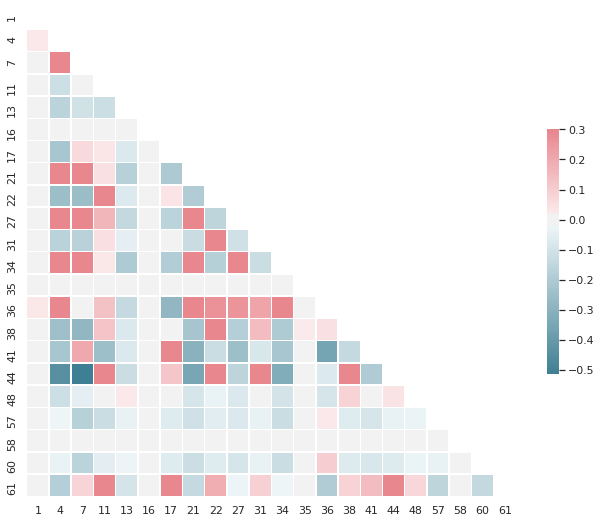

In [93]:
# Activations correlations heatmap
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})